# Importação das bibliotecas

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipinfo
import json


ipinfo_handler = ipinfo.getHandler("de30fe3213f197")

seed = 42
dataset_folder = "dataset/" 

pd.options.mode.chained_assignment = None  # default='warn'
np.random.seed(seed)
plt.rcParams['figure.figsize'] = (18,6)
plt.rcParams.update({'font.size': 15})

# Processamento do dataset

In [35]:
data = pd.read_csv(dataset_folder + "Darknet.CSV", low_memory=False)

In [90]:
_data = data.sample(frac=0.706565)

In [95]:
marim = _data[:50000]
paulo = _data[50000:]

marim.to_csv("marim_darknet")
paulo.to_csv("paulo_darknet")

In [93]:
samples = data.copy()

traffic_labels = samples["Label"].unique()
print(traffic_labels)
traffic_type_labels = samples["Label.1"].unique()
print(traffic_type_labels)

['Non-Tor' 'NonVPN' 'Tor' 'VPN']
['AUDIO-STREAMING' 'Browsing' 'Chat' 'Email' 'File-Transfer'
 'File-transfer' 'P2P' 'Video-Streaming' 'Audio-Streaming'
 'Video-streaming' 'VOIP']


In [38]:
samples['Label.1'].loc[samples['Label.1'] == 'AUDIO-STREAMING'] = 'Audio-Streaming'
samples['Label.1'].loc[samples['Label.1'] == 'File-transfer'] = 'File-Transfer'
samples['Label.1'].loc[samples['Label.1'] == 'Video-streaming'] = 'Video-Streaming'

traffic_type_labels = samples["Label.1"].unique()
print(traffic_type_labels)

['Audio-Streaming' 'Browsing' 'Chat' 'Email' 'File-Transfer' 'P2P'
 'Video-Streaming' 'VOIP']


In [39]:
samples['Label'].loc[(samples['Label'] == 'Non-Tor') | (samples['Label'] == 'NonVPN')] = 'Benign'
samples['Label'].loc[(samples['Label'] == 'Tor') | (samples['Label'] == 'VPN')] = 'Darknet'

traffic_labels = samples["Label"].unique()
print(traffic_labels)

['Benign' 'Darknet']


In [132]:
def get_ip_detail(ip, ip_dict, repeated):
    if ip not in ip_dict.keys():
        details = ipinfo_handler.getDetails(ip)
        ip_dict[ip] = details.all
    else:
        repeated += 1
    return repeated

def dump_ips(ip_dict, folder):
    j = json.dumps(ips_details)
    f = open(folder+"ips_dict.json","w")
    f.write(j)
    f.close()

In [133]:
ip_dict = {}
for src_ip, dst_ip in zip(marim["Src IP"], marim["Dst IP"]):
    print(f"Getting details of {src_ip}")
    repeated = get_ip_detail(src_ip, ip_dict)
    print(f"Getting details of {dst_ip}")
    repeated = get_ip_detail(dst_ip, ip_dict)
dump_ips(ip_dict, "")

Getting details of 131.202.243.21


TypeError: get_ip_detail() missing 1 required positional argument: 'repeated'

In [ ]:
n = 0
repeated = 0
for src_ip, dst_ip in zip(marim["Src IP"], marim["Dst IP"]):
    repeated = get_ip_detail(src_ip, ip_dict, repeated)
    repeated = get_ip_detail(dst_ip, ip_dict, repeated)
    if n % 50 == 0:
        print(f"{n+1} ips gathered")
        print(f"{repeated+1} duplicates\n")
    n += 1
dump_ips(ip_dict, "")

1 ips gathered
3 duplicates

51 ips gathered
103 duplicates

101 ips gathered
203 duplicates

151 ips gathered
303 duplicates

201 ips gathered
403 duplicates

251 ips gathered
503 duplicates

301 ips gathered
603 duplicates

351 ips gathered
703 duplicates

401 ips gathered
803 duplicates

451 ips gathered
903 duplicates

501 ips gathered
1003 duplicates

551 ips gathered
1103 duplicates

601 ips gathered
1203 duplicates

651 ips gathered
1303 duplicates

701 ips gathered
1403 duplicates

751 ips gathered
1503 duplicates

801 ips gathered
1603 duplicates

851 ips gathered
1703 duplicates

901 ips gathered
1803 duplicates

951 ips gathered
1903 duplicates

1001 ips gathered
2003 duplicates

1051 ips gathered
2103 duplicates

1101 ips gathered
2203 duplicates

1151 ips gathered
2303 duplicates

1201 ips gathered
2403 duplicates

1251 ips gathered
2503 duplicates

1301 ips gathered
2603 duplicates

1351 ips gathered
2703 duplicates

1401 ips gathered
2803 duplicates

1451 ips gathered
29

In [104]:
dump_ips(ips_details, "")

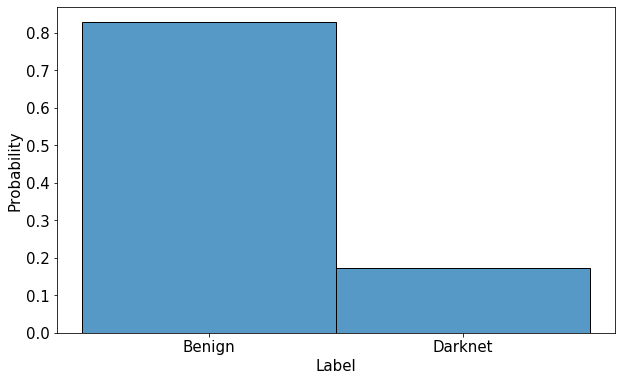

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(data=samples, x="Label", stat="probability")
plt.show()

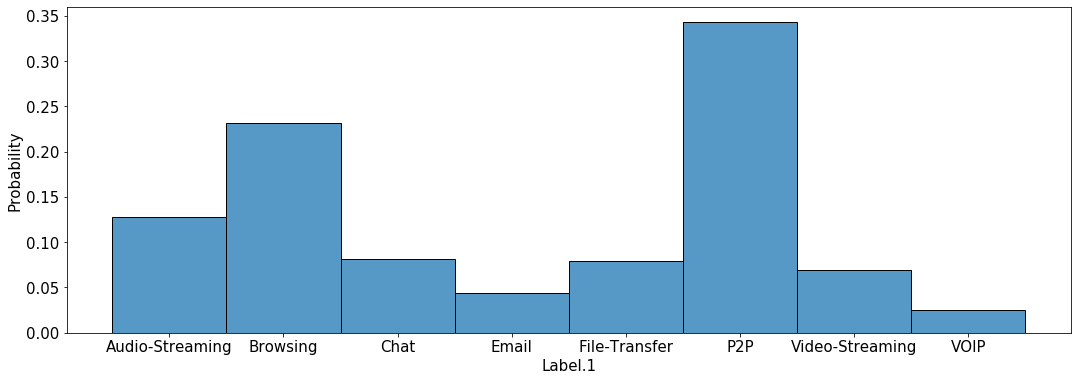

In [50]:
sns.histplot(data=samples, x="Label.1", stat="probability")
plt.show()

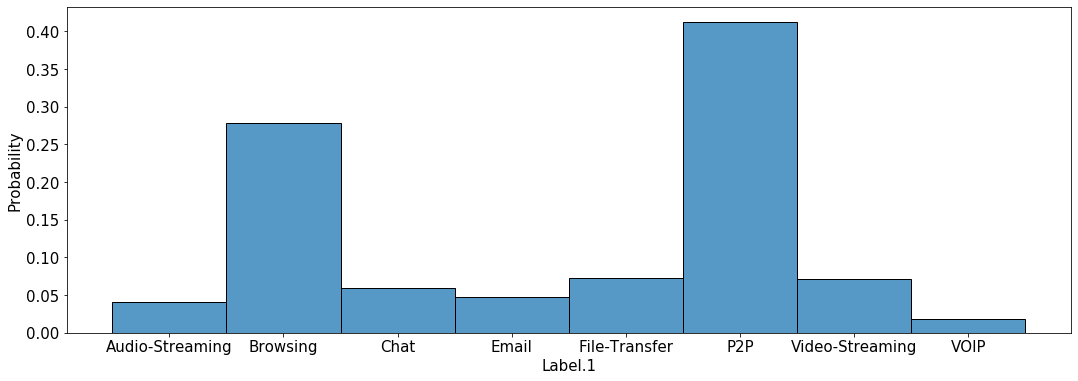

In [51]:
sns.histplot(data=samples[samples['Label'] == "Benign"], x="Label.1", stat="probability")
plt.show()

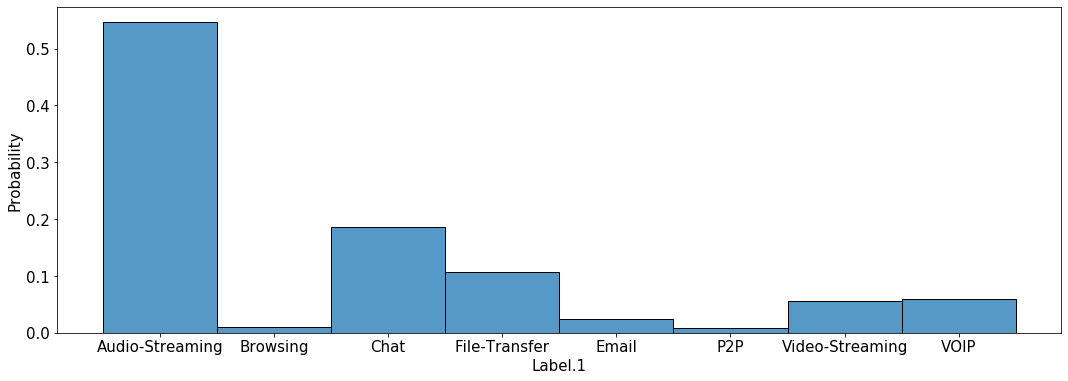

In [45]:
sns.histplot(data=samples[samples['Label'] == "Darknet"], x="Label.1", stat="probability")
plt.show()

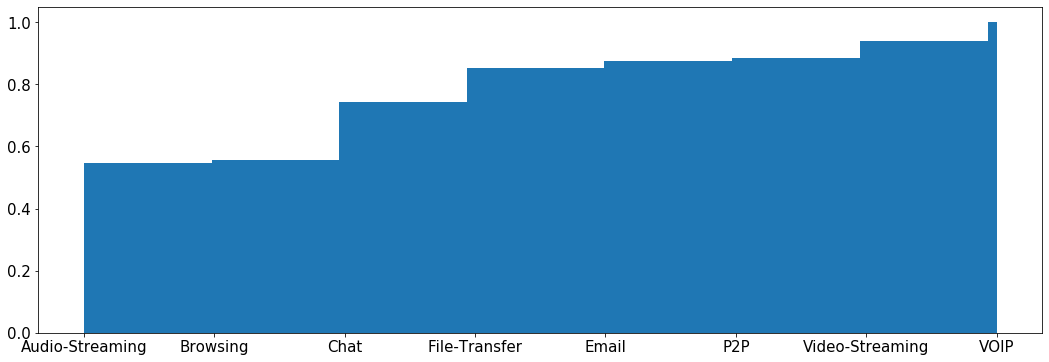

In [53]:
samples[samples['Label'] == "Darknet"]['Label.1'].hist(cumulative=True, density=1, bins=100, grid=False)
plt.show()

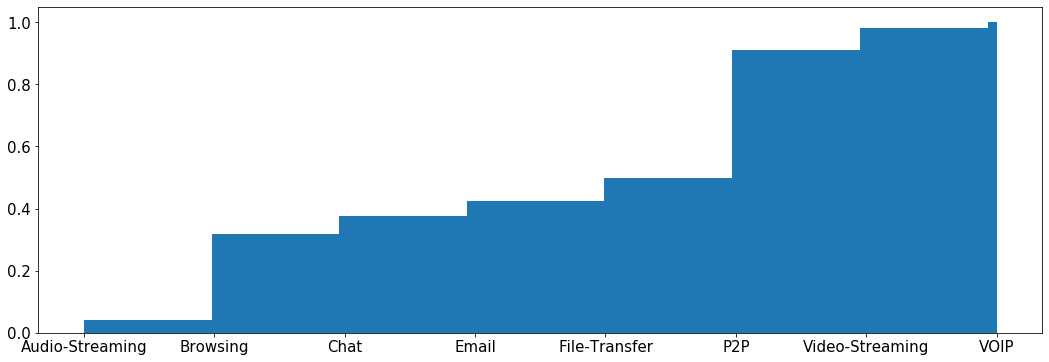

In [52]:
samples[samples['Label'] == "Benign"]['Label.1'].hist(cumulative=True, density=1, bins=100, grid=False)
plt.show()